# Lab: Machine learning  
*Using the cardiovascular disease dataset.*

## EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv("../data/cardio.csv", sep=";")
df = df.drop(columns=["id"])

In [3]:
# sns.countplot(data=df, x="cardio", hue="cardio", palette=["forestgreen", "crimson"], legend=False)
# plt.xticks(ticks=[0, 1], labels=["Healthy", "Sick"])
# plt.title("Balance of Cardiovascular Disease in the Dataset\n", fontweight="bold")
# plt.xlabel("")
# plt.ylabel("")
# plt.show()

In [4]:
# cholesterol_labels = ["normal", "above normal", "well above normal"]
# cholesterol_colours = ["forestgreen", "gold", "crimson"]
# plt.pie(df["cholesterol"].value_counts(), labels=cholesterol_labels, colors=cholesterol_colours, autopct="%1.1f%%", startangle=178)
# plt.show()

In [5]:
# sns.histplot(data=df, x="age", hue="cardio");

In [6]:
# sns.countplot(data=df, x="smoke", hue="cardio");

In [7]:
# sns.histplot(data=df, x="weight", hue="gender", bins=75);

In [8]:
# sns.histplot(data=df, x="height", hue="gender", bins=60);

In [9]:
# sns.countplot(data=df, x="cardio", hue="gender");

## Feature engineering
### BMI

In [10]:
df["bmi"] = df["weight"] / (df["height"] / 100) ** 2
df["bmi"] = df["bmi"].round(1)
df = df[["age", "gender", "height", "weight", "bmi", "ap_hi", "ap_lo", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"]]
df = df[(df["bmi"] > 16) & (df["bmi"] <= 40)]

Då labbinstruktionerna hänvisar till Wikipedia används de gränsvärden angivna där. Ursprunglig källa anges vara WHO och hänvisar till att människor med värden under 16 är "svårt tunna" medan de med värden över 40 lider av "fetma klass 3". 

In [11]:
bmi_labels = ["underweight", "normal", "overweight", "obese cl1", "obese cl2", "obese cl3"]
df["bmi_cat"] = pd.cut(df["bmi"], bins=[16, 18.5, 25, 30, 35, 40, float("inf")], labels=bmi_labels)
df = df[["age", "gender", "height", "weight", "bmi", "bmi_cat", "ap_hi", "ap_lo", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"]]

### blodtryck

In [12]:
df = df[(df["ap_hi"] >= 0) & (df["ap_hi"] <= 250) &
        (df["ap_lo"] >= 0) & (df["ap_lo"] <= 200)]

In [13]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 8))
# sns.boxplot(data=df, y="ap_hi", ax=ax[0])
# sns.boxplot(data=df, y="ap_lo", ax=ax[1])
# ax[0].set_title("Systolic Blood Pressure\n", fontweight="bold")
# ax[1].set_title("Diastolic Blood Pressure\n", fontweight="bold")
# ax[0].grid(axis='y')
# ax[1].grid(axis='y')
# ax[0].set_ylabel("")
# ax[1].set_ylabel("")
# plt.show()

Eftersom många outliers fortfarande är närvarande i datan används nedan IQR-metoden för att rensa fler outliers. 

In [ ]:
def clear_outliers(df):    
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    df = df[(df >= lower) & (df <= upper)]
    return df

df["ap_hi"] = clear_outliers(df["ap_hi"])
df["ap_lo"] = clear_outliers(df["ap_lo"])
df = df.dropna(how="any")

In [18]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 8))
# sns.boxplot(data=df, y="ap_hi", ax=ax[0])
# sns.boxplot(data=df, y="ap_lo", ax=ax[1])
# ax[0].set_title("Systolic Blood Pressure\n", fontweight="bold")
# ax[1].set_title("Diastolic Blood Pressure\n", fontweight="bold")
# ax[0].grid(axis='y')
# ax[1].grid(axis='y')
# ax[0].set_ylabel("")
# ax[1].set_ylabel("")
# plt.show()

In [19]:
bp_conditions = [
    (df["ap_hi"] <= 90) | (df["ap_lo"] <= 60), # with outlier I need | instead of & otherwise I get unknown values
    ((df["ap_hi"] >= 90) & (df["ap_hi"] < 120)) & (df["ap_lo"] < 80),
    ((df["ap_hi"] >= 120) & (df["ap_hi"] < 130)) & (df["ap_lo"] < 80),
    ((df["ap_hi"] >= 130) & (df["ap_hi"] < 140)) | ((df["ap_lo"] >= 80) & (df["ap_lo"] < 90)),
    ((df["ap_hi"] >= 140) & (df["ap_hi"] < 180)) | ((df["ap_lo"] >= 90) & (df["ap_lo"] < 120)),
    (df["ap_hi"] >= 180) | (df["ap_lo"] >= 120)
]
bp_labels = [
    "hypotension", 
    "normal", 
    "elevated", 
    "hypertension st1", 
    "hypertension st2", 
    "hypertension crisis"
]

df["ap_cat"] = np.select(bp_conditions, bp_labels, default="unknown")
df = df[["age", "gender", "height", "weight", "bmi", "bmi_cat", "ap_hi", "ap_lo", "ap_cat", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"]]

In [20]:
df.head()

,age,gender,height,weight,bmi,bmi_cat,ap_hi,ap_lo,ap_cat,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,22.0,normal,110.0,80.0,hypertension st1,1,1,0,0,1,0
1,20228,1,156,85.0,34.9,obese cl1,140.0,90.0,hypertension st2,3,1,0,0,1,1
2,18857,1,165,64.0,23.5,normal,130.0,70.0,hypertension st1,3,1,0,0,0,1
3,17623,2,169,82.0,28.7,overweight,150.0,100.0,hypertension st2,1,1,0,0,1,1
5,21914,1,151,67.0,29.4,overweight,120.0,80.0,hypertension st1,2,2,0,0,0,0


Då labbinstruktionerna hänvisar till Healthline används de gränsvärden angivna där. Det framgår även en källhänvisning till brittiska NHS som anger gränsvärden även för lågt blodtryck vilket implementerats här likaså. 

## Visualiseringar
### Andel sjukdomar

In [21]:
chol_gluc_labels = ["normal", "above normal", "well above normal"]
binary_labels = ["no", "yes"]

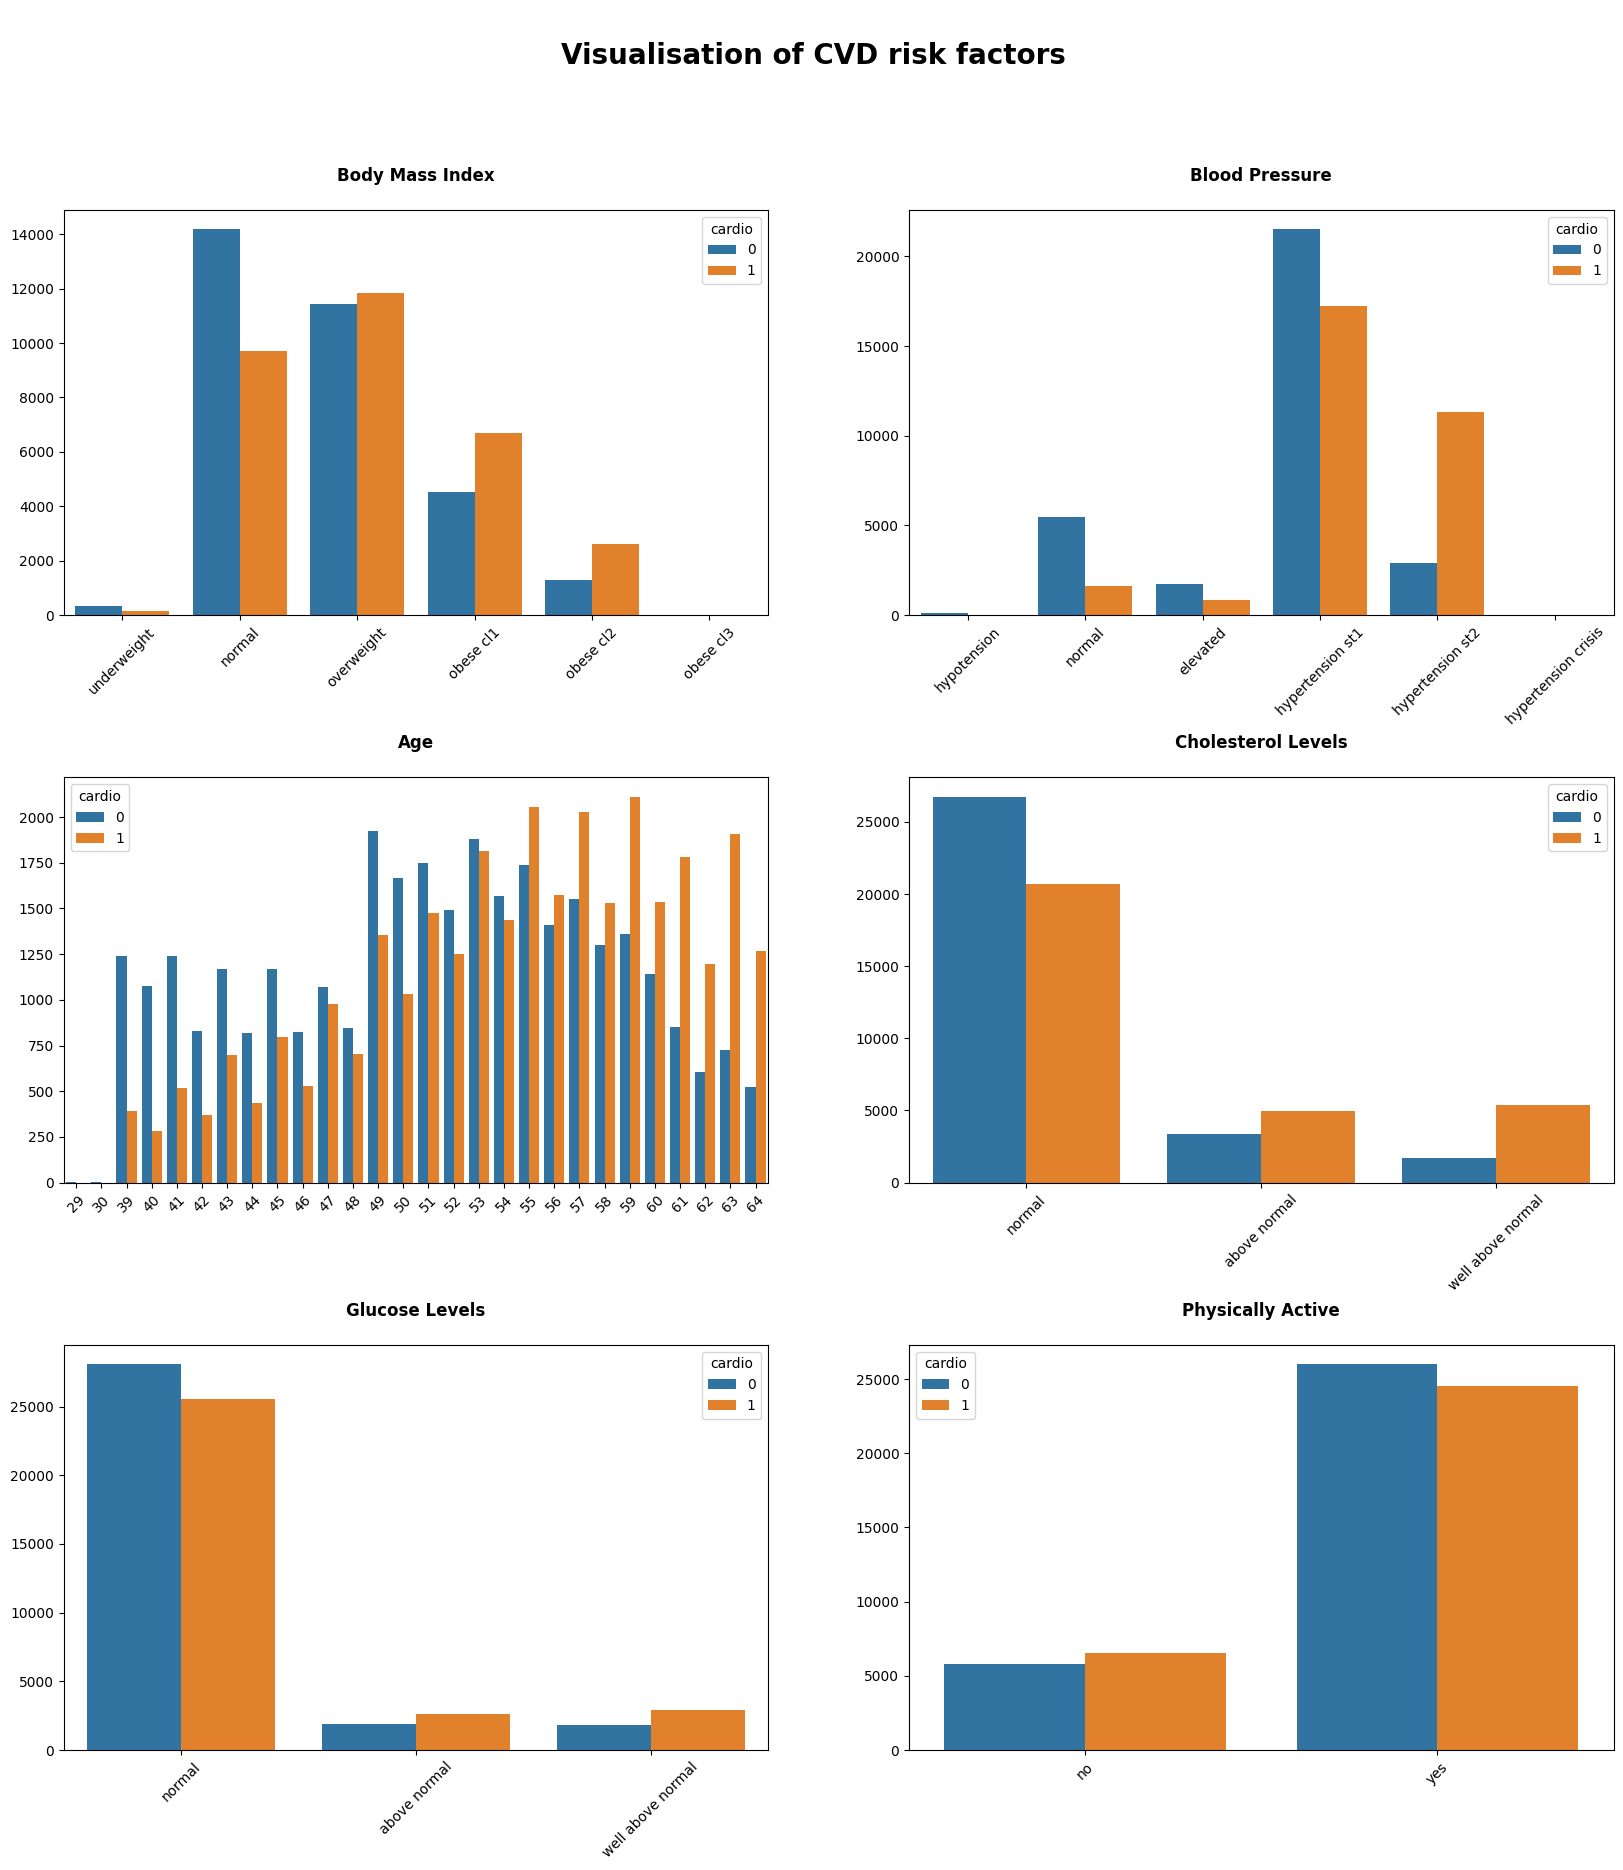

In [22]:
# TODO: barplots instead? 

fig, ax = plt.subplots(3, 2, figsize=(20, 20))

sns.countplot(data=df, x="bmi_cat", order=bmi_labels, hue="cardio", ax=ax[0, 0])
ax[0, 0].tick_params(axis="x", rotation=45)
ax[0, 0].set_title("Body Mass Index\n", fontweight="bold")
ax[0, 0].set_xlabel("")
ax[0, 0].set_ylabel("")

sns.countplot(data=df, x="ap_cat", order=bp_labels, hue="cardio", ax=ax[0, 1])
ax[0, 1].tick_params(axis="x", rotation=45)
ax[0, 1].set_title("Blood Pressure\n", fontweight="bold")
ax[0, 1].set_xlabel("")
ax[0, 1].set_ylabel("")

sns.countplot(data=df, x=(df["age"] // 365.25).astype(int), hue="cardio", ax=ax[1, 0])
ax[1, 0].tick_params(axis="x", rotation=45)
ax[1, 0].set_title("Age\n", fontweight="bold")
ax[1, 0].set_xlabel("")
ax[1, 0].set_ylabel("")

sns.countplot(data=df, x="cholesterol", hue="cardio", ax=ax[1, 1])
ax[1, 1].tick_params(axis="x", rotation=45)
ax[1, 1].set_xticks([0, 1, 2])
ax[1, 1].set_xticklabels(chol_gluc_labels)
ax[1, 1].set_title("Cholesterol Levels\n", fontweight="bold")
ax[1, 1].set_xlabel("")
ax[1, 1].set_ylabel("")

sns.countplot(data=df, x="gluc", hue="cardio", ax=ax[2, 0])
ax[2, 0].tick_params(axis="x", rotation=45)
ax[2, 0].set_xticks([0, 1, 2])
ax[2, 0].set_xticklabels(chol_gluc_labels)
ax[2, 0].set_title("Glucose Levels\n", fontweight="bold")
ax[2, 0].set_xlabel("")
ax[2, 0].set_ylabel("")

sns.countplot(data=df, x="active", hue="cardio", ax=ax[2, 1])
ax[2, 1].tick_params(axis="x", rotation=45)
ax[2, 1].set_xticks([0, 1])
ax[2, 1].set_xticklabels(binary_labels)
ax[2, 1].set_title("Physically Active\n", fontweight="bold")
ax[2, 1].set_xlabel("")
ax[2, 1].set_ylabel("")

# fig.delaxes(ax[2, 1])  # Remove the empty subplot

fig.suptitle("\nVisualisation of CVD risk factors", fontweight="bold", fontsize=20)
plt.subplots_adjust(hspace=0.4)
plt.show()

### Korrelation

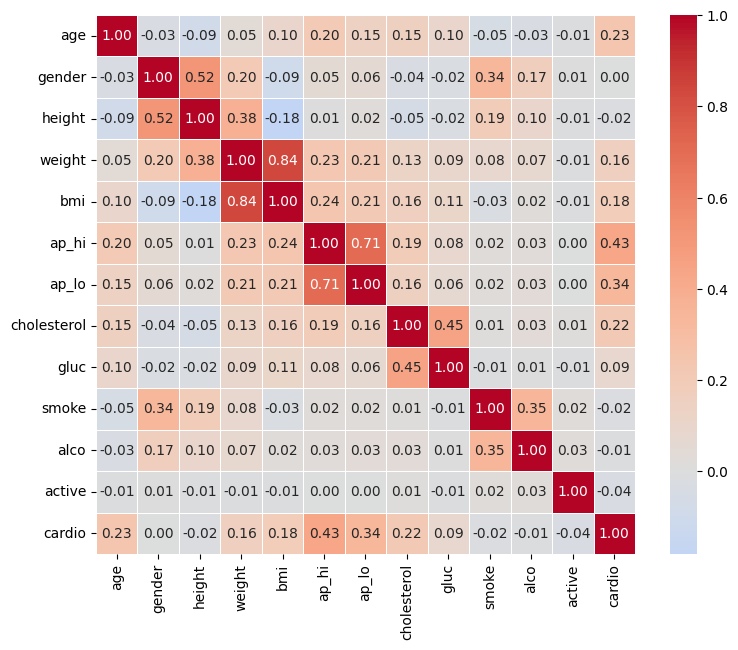

In [23]:
# TODO: change all values to numeric
numerical_columns = df.describe().columns.to_list()
corr = df[numerical_columns].corr()
plt.figure(figsize=(9, 7))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True, linewidths=0.5)
plt.show()

BMI och vikt samt systoliskt och diastoliskt blodtryck kan ignoreras pga deras uppenbara relationer. Detsamma skulle kunna sägas för glukos och kolesterol.  

Mer intressanta observationer för detta dataset är att rökning har en viss relation till alkoholkonsumption men även kön.  

För syftet med labben är den sista raden den enda viktiga, korrelationer med vår responsvariabel. Då BMI har en högre korrelation än de separata variablerna för höjd och vikt vore det intressant att veta hur vår nuvarande kategoriska variabel för blodtryck påverkas. Andra kolumner av värde är ålder och kolesterol. 

## Dataset

In [24]:
df_a = df.copy().drop(columns=["height", "weight", "bmi", "ap_hi", "ap_lo"])
df_b = df.copy().drop(columns=["height", "weight", "bmi_cat", "ap_cat"])

df_a = pd.get_dummies(df_a, columns=["gender", "bmi_cat", "ap_cat"])
df_b = pd.get_dummies(df_b, columns=["gender"])

## !! Cutting down dataset size !!
*For  more performance during experimentation.*

In [25]:
# df_a.shape is (62830, 20)
# cutting it down to increase performance

def dataset_trimmer(df, remainder=0.125): 
    
    df_cut = df.copy()
    df_cut = df_cut.sample(frac=remainder, random_state=42)

    return df_cut


df_a = dataset_trimmer(df_a)
df_b = dataset_trimmer(df_b)

## Modeller

In [26]:
def splits(df):

    X_train, X_temp, y_train, y_temp = train_test_split(
        df.drop("cardio", axis=1), 
        df["cardio"], 
        test_size=0.3, 
        random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, 
        y_temp, 
        test_size=0.5, 
        random_state=42
    )
    return X_train, X_val, X_test, y_train, y_val, y_test


X_train_a, X_val_a, X_test_a, y_train_a, y_val_a, y_test_a = splits(df_a)
X_train_b, X_val_b, X_test_b, y_train_b, y_val_b, y_test_b = splits(df_b)

In [27]:
def standardiser(X_train, X_val, X_test):

    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_val_std = scaler.transform(X_val)
    X_test_std = scaler.transform(X_test)
    
    return X_train_std, X_val_std, X_test_std


def normaliser(X_train, X_val, X_test):
    
    scaler = MinMaxScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_val_norm = scaler.transform(X_val)
    X_test_norm = scaler.transform(X_test)
    
    return X_train_norm, X_val_norm, X_test_norm

In [28]:
X_train_a, X_val_a, X_test_a = standardiser(X_train_a, X_val_a, X_test_a)
X_train_b, X_val_b, X_test_b = standardiser(X_train_b, X_val_b, X_test_b)
X_train_a, X_val_a, X_test_a = normaliser(X_train_a, X_val_a, X_test_a)
X_train_b, X_val_b, X_test_b = normaliser(X_train_b, X_val_b, X_test_b)

## HPO on single model

In [29]:
param_grids = {
    "log_reg": {
        "model": LogisticRegression(),
        "params": {
            "C": [
                0.01,
                0.1,
                1,
                10,
                100,
            ],
            "solver": ["liblinear", "saga", "lbfgs"], 
            "penalty": ["l1", "l2", "elasticnet", None], # best: None
            "max_iter": [10000],
            # "random_state": [42]
        }
    }
}

In [30]:
for index, row in scores.iterrows():    
    print(f"{row["model"]}: {row['best_params']}")

display(scores)

NameError: name 'scores' is not defined

In [ ]:
for index, row in scores.iterrows():    
    print(f"Model: {index}, Best Params: {row['best_params']}")

display(scores)

Model: 0, Best Params: {'C': 0.01, 'max_iter': 10000, 'penalty': None, 'solver': 'lbfgs'}


,model,best_params,train_score,val_score
0,LogisticRegression(),"{'C': 0.01, 'max_iter': 10000, 'penalty': None...",0.60982,0.568595


In [ ]:
results = {}

for key, values in param_grids.items():
    print(f"\nTraining {key} ...")

    model = values["model"]
    params = values["params"]

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=5,
        scoring="recall",
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(X_train_a, y_train_a)

    results[key] = {
        "model": model,
        "best_params": grid_search.best_params_,
        "train_score": grid_search.score(X_train_a, y_train_a),
        "val_score": grid_search.score(X_val_a, y_val_a)
    }


Training log_reg ...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END ...C=0.01, max_iter=10000, penalty=l1, solver=lbfgs; total time=   0.0s[CV] END ...C=0.01, max_iter=10000, penalty=l1, solver=lbfgs; total time=   0.0s

[CV] END C=0.01, max_iter=10000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=10000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=10000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=10000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.01, max_iter=10000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=0.01, max_iter=10000, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....C=0.01, max_iter=10000, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....C=0.01, max_iter=10000, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....C=0.01, max_iter=10000, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....C=0.01,

/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarn

[CV] END .C=0.01, max_iter=10000, penalty=None, solver=lbfgs; total time=   0.0s
[CV] END .C=0.01, max_iter=10000, penalty=None, solver=lbfgs; total time=   0.0s
[CV] END .C=0.01, max_iter=10000, penalty=None, solver=lbfgs; total time=   0.0s
[CV] END .C=0.01, max_iter=10000, penalty=None, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, max_iter=10000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END .C=0.01, max_iter=10000, penalty=None, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, max_iter=10000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..C=0.01, max_iter=10000, penalty=None, solver=saga; total time=   0.0s
[CV] END ....C=0.1, max_iter=10000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=0.1, max_iter=10000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=0.1, max_iter=10000, penalty=l1, solver=lbfgs; total time=   0.0s[CV] END ....C=0.1, max_iter=10000, penalty=l1, solver=lbfgs; total time=   0.0s

[CV] END ....C=0.1, max_iter

/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarn

[CV] END ....C=10, max_iter=10000, penalty=None, solver=saga; total time=   0.0s
[CV] END C=100, max_iter=10000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=100, max_iter=10000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=100, max_iter=10000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=100, max_iter=10000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....C=100, max_iter=10000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....C=100, max_iter=10000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....C=100, max_iter=10000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END C=100, max_iter=10000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, max_iter=10000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=100, max_iter=10000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .......C=1, max_iter=10000, penalty=l2, solver=saga; total time=   0.1s
[CV] END C=100, max_iter=100

/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...C=100, max_iter=10000, penalty=None, solver=saga; total time=   0.1s
[CV] END ......C=10, max_iter=10000, penalty=l2, solver=saga; total time=   0.4s
[CV] END .....C=10, max_iter=10000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...C=100, max_iter=10000, penalty=None, solver=saga; total time=   0.1s
[CV] END ......C=10, max_iter=10000, penalty=l2, solver=saga; total time=   0.4s
[CV] END .....C=10, max_iter=10000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=10, max_iter=10000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=10, max_iter=10000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=10, max_iter=10000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=10, max_iter=10000, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END ...C=100, max_iter=10000, penalty=None, solver=saga; total time=   0.0s
[CV] END C=10, max_iter=10000, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END .....

/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ....C=10, max_iter=10000, penalty=None, solver=saga; total time=   1.7s
[CV] END .....C=100, max_iter=10000, penalty=l2, solver=saga; total time=   0.7s
[CV] END ....C=10, max_iter=10000, penalty=None, solver=saga; total time=   0.0s
[CV] END ...C=10, max_iter=10000, penalty=None, solver=lbfgs; total time=   0.0s
[CV] END ...C=100, max_iter=10000, penalty=None, solver=saga; total time=   1.6s


/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END ...C=100, max_iter=10000, penalty=None, solver=saga; total time=   0.0s
[CV] END ..C=100, max_iter=10000, penalty=None, solver=lbfgs; total time=   0.0s
[CV] END ..C=100, max_iter=10000, penalty=None, solver=lbfgs; total time=   0.0s
[CV] END ..C=100, max_iter=10000, penalty=None, solver=lbfgs; total time=   0.0s
[CV] END ..C=100, max_iter=10000, penalty=None, solver=lbfgs; total time=   0.0s
[CV] END ..C=100, max_iter=10000, penalty=None, solver=lbfgs; total time=   0.0s
[CV] END .....C=100, max_iter=10000, penalty=l1, solver=saga; total time=   2.1s


/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarn

[CV] END .....C=100, max_iter=10000, penalty=l2, solver=saga; total time=   0.6s
[CV] END .....C=100, max_iter=10000, penalty=l2, solver=saga; total time=   0.2s
[CV] END .....C=100, max_iter=10000, penalty=l2, solver=saga; total time=   1.2s
[CV] END ....C=100, max_iter=10000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....C=100, max_iter=10000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....C=100, max_iter=10000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .....C=100, max_iter=10000, penalty=l1, solver=saga; total time=   1.9s
[CV] END .....C=100, max_iter=10000, penalty=l1, solver=saga; total time=   1.3s
[CV] END .....C=100, max_iter=10000, penalty=l1, solver=saga; total time=   0.7s
[CV] END .....C=100, max_iter=10000, penalty=l1, solver=saga; total time=   1.6s
[CV] END ....C=100, max_iter=10000, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....C=100, max_iter=10000, penalty=l1, solver=lbfgs; total time=   0.0s


/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
125 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/albotgoodman/coding/repos/machine-learning/.venv/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kw

In [ ]:
scores = pd.DataFrame(results).T
scores.sort_values(by="val_score", ascending=False, inplace=True)
scores.reset_index(drop=True, inplace=True)
scores.to_csv("results/draft_scores.csv", index=False)

## HPO on all

In [ ]:
# # The structure of the following dictionary was inspired by:
# # Codebasics on Youtube, https://www.youtube.com/watch?v=HdlDYng8g9s

# param_grids = {
#     "log_reg": {
#         "model": LogisticRegression(),
#         "params": {
#             "C": [
#                 #   0.00000000000001,
#                 #   0.0000000000001,
#                 #   0.000000000001,
#                 #   0.00000000001, 
#                 #   0.0000000001, 
#                 #   0.000000001, 
#                 #   0.00000001, 
#                 #   0.0000001, 
#                 #   0.000001, 
#                 #   0.00001, 
#                 #   0.0001,
#                 #   0.001,
#                 #   0.01,
#                   0.1,
#                   1,
#                   10,
#                   100,
#                   1000],
#             "penalty": ["l1", "l2", "elasticnet", None], # best: None
#             "solver": ["saga", "liblinear", "lbfgs"], # best: "lbfgs" 
#             "max_iter": [10000],
#             "random_state": [42]
#         }
#     },
#     "sgd": {
#         "model": SGDClassifier(),
#         "params": {
#             "loss": ["log_loss", "hinge", "modified_huber", "perceptron"],
#             "penalty": ["l1", "l2", "elasticnet", None],
#             "alpha": [0.000001, 
#                       0.00001, 
#                       0.0001, 
#                       0.001, 
#                       0.01, 
#                       0.1, 
#                       1,
#                       10,
#                       100,
#                       1000],
#             "max_iter": [10000],
#             "learning_rate": ["optimal", "invscaling", "adaptive"],
#             "random_state": [42]
#         }
#     },
#     "svm": {
#         "model": SVC(),
#         "params": {
#             "C": [3, 6, 9, 20],
#             "gamma": ["scale", "auto"],
#             "degree": [2, 3], # best: 2
#             "kernel": ["sigmoid", "poly", "rbf"],
#             "random_state": [42]
#         }
#     },
#     "knn": {
#         "model": KNeighborsClassifier(),
#         "params": {
#             "n_neighbors": [4, 5, 6, 10],
#             "weights": ["uniform", "distance"], 
#             "algorithm": ["auto", "kd_tree", "ball_tree", "brute"], 
#             "leaf_size": [1, 2], # best: 1
#             "p": [1, 2], # best: 1
#         }
#     },
#     "rforest": {
#         "model": RandomForestClassifier(),
#         "params": {
#             "n_estimators": [8, 12, 20, 30], 
#             "criterion": ["gini", "entropy"],
#             "max_depth": [None, 2, 10], # best: None
#             "min_samples_split": [20, 25, 30],
#             "random_state": [42]
#         }
#     }
# }

In [ ]:
# for index, row in scores.iterrows():    
#     print(f"Model: {index}, Best Params: {row['best_params']}")

# display(scores)

In [ ]:
# for index, row in scores.iterrows():
#     print(f"Model: {index}, Best Params: {row['best_params']}")

# display(scores)

In [ ]:
# results = {}

# for key, values in param_grids.items():
#     print(f"\nTraining {key} ...")

#     model = values["model"]
#     params = values["params"]

#     grid_search = GridSearchCV(
#         estimator=model,
#         param_grid=params,
#         cv=5,
#         scoring="recall",
#         verbose=2,
#         n_jobs=-1
#     )

#     grid_search.fit(X_train_a, y_train_a)

#     results[key] = {
#         "best_params": grid_search.best_params_,
#         "best_score": grid_search.best_score_,
#         "train_score": grid_search.score(X_train_a, y_train_a),
#         "val_score": grid_search.score(X_val_a, y_val_a)
#     }

#     print(f"Best parameters: {grid_search.best_params_}")
#     print(f"Validation score: {grid_search.score(X_train_a, y_train_a):.4f}")

In [ ]:
# scores = pd.DataFrame(results).T
# scores.sort_values(by="val_score", ascending=False, inplace=True)
# scores.to_csv("results/draft_scores.csv", index=True)